<div>
<img src="https://www.nasa.gov/wp-content/uploads/2024/07/osdr-gl4hs-logo.png" width="600"/>
</div>

# **NOTEBOOK 6: Performing differential gene expression analysis**
In this notebook, you will run statistical tests to determine which genes are differentially expressed between ground control and space flight groups.

## **Objectives of this notebook**
The primary objective of this notebook is to perform [differential gene expression analysis](https://www.youtube.com/watch?v=tlf6wYJrwKY) (DGEA) using [Python's implementation of DESeq2](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_step_by_step.html#sphx-glr-auto-examples-plot-step-by-step-py) to find genes which have a large enough [log2 fold change](https://www.biostars.org/p/9505003/) between ground control and space flight as well as a low enough adjusted [p-value](https://www.youtube.com/watch?v=vemZtEM63GY) as to be statistically significant.

DGEA is actually a series of several [statistical hypothesis tests](https://www.youtube.com/watch?v=0oc49DyA3hU) - one per gene - that compares the expression of that gene between 2 groups (e.g. spaceflight vs ground control). The null hypothesis is that there is no significant difference in the expression of that gene between the 2 groups. The alternate hypothesis is that there is a significant difference between the expression of that gene between those 2 groups. This difference can either be over-regulated gene expression or under-regulated gene expression, making this a [two-tailed test](https://www.youtube.com/watch?v=bsZGt-caXO4).

Additionally, you will use principal components analysis (PCA) to visualize the gene expression of all the samples in your dataset to determine if the samples separate according to their condition (e.g. space flight and ground control). You can learn more about PCA [here](https://youtu.be/HMOI_lkzW08?si=zTSi-OclCvmEvdVR). After performing DGEA, you will create a volcano plot of the p-values to visualize their distribution. You can learn more about volcano plots [here](https://www.youtube.com/watch?v=7aWAdw2jhj0).

We will no longer use the FASTQ data from the previous notebooks regarding the single sample paired end reads. Instead, we will download the GeneLab-processed count data for all the samples in your dataset and use that as our starting point for this and the next notebook.

## **UNIX commands introduced in this notebook**

[`unzip`](https://linux.die.net/man/1/unzip) command to extract the files in a ZIP archive.

# Prepare runtime environment for lab

In [ ]:
# mount google drive to mnt mount point
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt")


Mounted at mnt


In [ ]:
# time the notebook
import datetime
start_time = datetime.datetime.now()
print('notebook start time: ', start_time.strftime('%Y-%m-%d %H:%M:%S'))

notebook start time:  2025-09-21 22:05:02


In [ ]:
# define OSD dataset number to use for this notebook

# OSD_DATASET='511'
# GLDS_DATASET='511'

#OSD_DATASET='678'
#GLDS_DATASET='612'

#OSD_DATASET='104'
#GLDS_DATASET='104'

OSD_DATASET='254'
GLDS_DATASET='254'

#OSD_DATASET='580'
#GLDS_DATASET='573'

#OSD_DATASET='137'
#GLDS_DATASET='137'

#OSD_DATASET='47'
#GLDS_DATASET='47'

#OSD_DATASET='48'
#GLDS_DATASET='48'

#OSD_DATASET='120'
#GLDS_DATASET='120'

#OSD_DATASET='245'
#GLDS_DATASET='245'



In [ ]:
# define factors for experiment
# NOTE: the configs listed below are examples that work with specific OSD datasets
# these configs will not necessarily work with the OSD dataset that you've chosen
# We defined 5 different configs, but on the bottom of this cell, we only choose
# one of them and store in a variable called "config". You can run one config for
# the notebook at a time, and the results for each config will be stored separately.
# The results of this experiment will be stored in your google drive under
# NASA/GL4HS/CAPSTONE/<experiment name>

# young GC vs old GC
config_1 = {
    'experiment name': 'young_GC_vs_old_GC',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '32'}
}

# young FLT vs old FLT
config_2 = {
    'experiment name': 'young_FLT_vs_old_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '32'}
}

# young GC vs young FLT
config_3 = {
    'experiment name': 'young_GC_vs_young_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '10 to 12'}
}

# old GC vs old FLT
config_4 = {
    'experiment name': 'old_GC_vs_old_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '32'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '32'}
}

# FLT vs GC
config_5 = {
    'experiment name': 'FLT_vs_GC',
    'factor_list': ['Factor Value[Spaceflight]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight'},
    'group_B': {'Factor Value[Spaceflight]': 'Ground Control'}
}

# YNG vs OLD
config_6 = {
    'experiment name': 'YNG_vs_OLD',
    'factor_list': ['Factor Value[Age]'],
    'group_A': {'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Age]': '32'}
}

# LONG vs SHORT
config_7 = {
    'experiment name': 'LONG_vs_SHORT',
    'factor_list': ['Factor Value[Duration]'],
    'group_A': {'Factor Value[Duration]': '~25'},
    'group_B': {'Factor Value[Duration]': '~75'}
}

# FLIGHT LONG vs FLIGHT SHORT
config_8 = {
    'experiment name': 'FLIGHT_LONG_vs_FLIGHT_SHORT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Duration]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Duration]': '~25'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Duration]': '~75'}
}

config = config_5


In [ ]:
# define the threshold for coefficient of variation
CV_THRESH=0.5

In [ ]:
# define log2 fold change threshold
LOG2FC_THRESH = 1.5

In [ ]:
# define alpha level of significance
ALPHA_LEVEL = 0.05

In [ ]:
# create output directory
import os
OUTPUT_DIR="/content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/" + OSD_DATASET + '/' + config['experiment name']
if not os.path.exists(OUTPUT_DIR):
  !mkdir -p {META_DIR}

In [ ]:
# create META_DIR directory for metadata
import os
META_DIR=OUTPUT_DIR + "/META/"
if os.path.exists(META_DIR):
  !rm -rf {META_DIR}
!mkdir -p {META_DIR}

In [ ]:
# create DGEA_DIR directory for DGEA output
DGEA_DIR=OUTPUT_DIR + "/DGEA/"
if os.path.exists(DGEA_DIR):
  !rm -rf {DGEA_DIR}

!mkdir -p {DGEA_DIR}

In [ ]:
# install packages and import the modules needed to do DGEA
!pip install pyDeseq2 > /dev/null
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
!pip install scikit-learn > /dev/null
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
!pip install Ensembl_converter > /dev/null
from Ensembl_converter import EnsemblConverter
!pip install mygene > /dev/null
import mygene

In [ ]:
import pydeseq2 as deseq
print(deseq.__version__)

0.5.2


# Define Python methods for notebook

In [ ]:
# define method for removing NaNs from dataframe
def drop_nans(df):
  # drop NaN rows
  df = df.dropna(inplace=False)
  return df

You can learn more about Python NaN [here](https://stackoverflow.com/questions/17628613/what-is-inf-and-nan).

In [ ]:
# define method for dropping low-count genes
def drop_lowcount(df, threshold=10):

  # let's drop any low-count genes
  if 'transcript' in df.columns:
    df = df[df.drop(columns=['transcript']).sum(axis=1) >= threshold]
  elif 'Unnamed: 0' in df.columns:
    df = df[df.drop(columns=['Unnamed: 0']).sum(axis=1) >= threshold]
  else:
    raise Exception("check file format")
  return df


You can read more about low-count gene thresholds [here](https://www.biostars.org/p/251922/).

In [ ]:
# define method for filtering low coefficient-of-variation genes
def filter_cvs(df, thresh):
  import numpy as np
  import matplotlib.pyplot as plt

  # calculate coefficient of variation
  cvs=list()
  for i in range(len(df)):
    m = np.mean(df.iloc[i][1:])
    sd = np.std(df.iloc[i][1:])
    cvs.append(sd/m)

  # plot hist of dist of coev of variation
  fig, axs = plt.subplots()
  axs.hist(cvs, bins=20)

  # add labels for x and y axes
  plt.xlabel('coefficient of variation')
  plt.ylabel('number of genes')

  # keep genes with cv > thresh
  indices = list()
  for i in range(len(cvs)):
    if cvs[i] > thresh:
      indices.append(i)
  return df.iloc[indices]


You can read more about the coefficient of variation [here](https://en.wikipedia.org/wiki/Coefficient_of_variation).

In [ ]:
# define method to transpose a dataframe
def transpose_df(df, cur_index_col, new_index_col):
  df = df.set_index(cur_index_col).T
  df.reset_index(level=0, inplace=True)
  cols = [new_index_col] + list(df.columns)[1:]
  df.columns = cols
  return df

You can read more about transposition [here](https://www.geeksforgeeks.org/python-pandas-dataframe-transpose/).

In [ ]:
# define method for dropping ERCC genes from dataframe
def drop_ercc(df):
  df = df[df['Unnamed: 0'].str.contains('ERCC-') == False]
  return df

You can read more about ERCC [here](https://www.nist.gov/programs-projects/external-rna-controls-consortium).

In [ ]:
# define method for running PCA
def run_pca(_expr, _meta, samples_0, samples_1, factor_list):

  X = np.array(_expr.drop(columns=['sample']))
  y = np.array(list(factor_list))
  target_names=np.array(['group 0', 'group 1'])

  # run PCA to reduce dimensions
  pca = PCA(n_components=2)
  X_r = pca.fit_transform(X)

  # Percentage of variance explained for each components
  print(
      "explained variance ratio (first two components): %s"
      % str(pca.explained_variance_ratio_)
  )

  # plot the pca plot
  plt.figure()
  colors = ["blue", "red"]
  lw = 2
  for color, i, target_name in zip(colors, ['0', '1'], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name)
  plt.legend(loc="best", shadow=False, scatterpoints=1)
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.title("PCA of OSD dataset")

  # show the last digits of the sample name if the number of samples is less than 40
  if len(_expr) < 100:
    samples = list(_expr['sample'])
    for i, txt in enumerate(samples):
        plt.annotate(txt[-8:], (X_r[i][0], X_r[i][1]))

  return plt

In [ ]:
# define method to convert ensembl gene id's to gene symbols
def old_get_symbol_from_id(gene_id_list):
  # Create an instance of EnsemblConverter
  converter = EnsemblConverter()

  # Convert Ensembl IDs to gene symbols
  result = converter.convert_ids(gene_id_list)

  # Print the resulting DataFrame
  gene_symbol_list = list()
  for i in range(len(result)):
    gene_symbol_list.append(result.iloc[i]['Symbol'])

  return gene_symbol_list

In [ ]:
# define method to convert gene ids to symbols
def get_symbol_from_id(gene_list):
  import mygene

  symbol_list = list()
  mg = mygene.MyGeneInfo()
  ginfo = mg.querymany(gene_list, scopes='ensembl.gene')
  seen_genes = list()
  for g in ginfo:
    if g['query'] in seen_genes:
      continue
    if not 'symbol' in g:
      symbol_list.append(g['query'])
    else:
      symbol_list.append(g['symbol'])
    seen_genes.append(g['query'])
  return symbol_list

# Download data from OSDR

In [ ]:
# open the URL printed below in another browser window
osd_url = !echo https://visualization.osdr.nasa.gov/biodata/api/v2/dataset/OSD-{OSD_DATASET}/files/\?format=browser
print(osd_url[0])

https://visualization.osdr.nasa.gov/biodata/api/v2/dataset/OSD-254/files/?format=browser


In [ ]:
# download OSD unnormalized count data
# NOTE: if you get an error (HTTP 404) in this cell, then open the link at the top of this section,
# find and copy the exact URL for the expression ZIP file for your dataset, and replace the
# url variable below with the exact URL for your dataset.
# if the link in the previous cell is broken, visit the OSDR Web page for your dataset to find the filenames
# and adjust the url below accordingly

import pandas as pd
url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + '/download?source=datamanager&file=GLDS-' + GLDS_DATASET + '_rna_seq_Unnormalized_Counts.csv'
# url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + '/download?source=datamanager&file=GLDS-' + GLDS_DATASET + '_rna_seq_STAR_Unnormalized_Counts.csv'
#url='https://osdr.nasa.gov/geode-py/ws/studies/OSD-678/download?source=datamanager&file=GLDS-612_rna_seq_STAR_Unnormalized_Counts_GLbulkRNAseq.csv'
#url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-511/download?source=datamanager&file=GLDS-511_rna_seq_STAR_Unnormalized_Counts.csv'
#url='https://osdr.nasa.gov/geode-py/ws/studies/OSD-254/download?source=datamanager&file=' + 'GLDS-254_rna_seq_Unnormalized_Counts.csv'

expr_df = pd.read_csv(url)
expr_df.head()

,Unnamed: 0,Mmus_C57-6J_SKN_BSL_0days_Rep1_B1,Mmus_C57-6J_SKN_BSL_0days_Rep2_B3,Mmus_C57-6J_SKN_BSL_0days_Rep3_B5,Mmus_C57-6J_SKN_BSL_0days_Rep4_B7,Mmus_C57-6J_SKN_BSL_0days_Rep5_B9,Mmus_C57-6J_SKN_BSL_0days_Rep6_B11,Mmus_C57-6J_SKN_BSL_0days_Rep7_B13,Mmus_C57-6J_SKN_BSL_0days_Rep8_B15,Mmus_C57-6J_SKN_BSL_0days_Rep9_B17,...,Mmus_C3H-HeJ_SKN_VIV_25days_Rep1_V2,Mmus_C3H-HeJ_SKN_VIV_25days_Rep2_V6,Mmus_C3H-HeJ_SKN_VIV_25days_Rep3_V10,Mmus_C3H-HeJ_SKN_VIV_25days_Rep4_V14,Mmus_C3H-HeJ_SKN_VIV_25days_Rep5_V18,Mmus_C3H-HeJ_SKN_VIV_75days_Rep1_V4,Mmus_C3H-HeJ_SKN_VIV_75days_Rep2_V8,Mmus_C3H-HeJ_SKN_VIV_75days_Rep3_V12,Mmus_C3H-HeJ_SKN_VIV_75days_Rep4_V16,Mmus_C3H-HeJ_SKN_VIV_75days_Rep5_V20
0,ENSMUSG00000000001,7239.0,9555.0,8706.0,7770.0,9137.0,12668.00,8073.0,7160.0,7583.0,...,10282.0,10621.0,9099.0,5772.0,7287.0,9590.0,10685.0,7008.0,7189.0,6756.0
1,ENSMUSG00000000003,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSMUSG00000000028,71.0,109.0,70.0,216.0,129.0,158.00,118.0,226.0,268.0,...,206.0,88.0,104.0,526.0,216.0,49.0,98.0,153.0,237.0,170.0
3,ENSMUSG00000000031,5763.0,3297.0,3041.0,8334.0,720.0,2488.58,860.0,5504.0,5026.0,...,3870.0,1086.0,4472.0,6997.0,3940.0,1947.0,6060.0,4390.0,11112.0,20944.0
4,ENSMUSG00000000037,332.0,416.0,453.0,355.0,424.0,509.00,500.0,361.0,348.0,...,823.0,727.0,648.0,310.0,591.0,694.0,710.0,592.0,563.0,503.0


In [ ]:
# identify the shape of the expr_df dataframe
expr_df.shape

(55628, 81)

In [ ]:
# call drop_ercc
# there may or may not be ERCC records to drop
expr_df = drop_ercc(expr_df)
expr_df.shape

(55536, 81)

In [ ]:
# call drop_nans
# there may or may not be NaNs to drop
expr_df = drop_nans(expr_df)
expr_df.shape

(55536, 81)

In [ ]:
# call drop_lowcount with threshold=50
expr_df = drop_lowcount(expr_df, threshold=50)
expr_df.shape

(26724, 81)

(15620, 81)

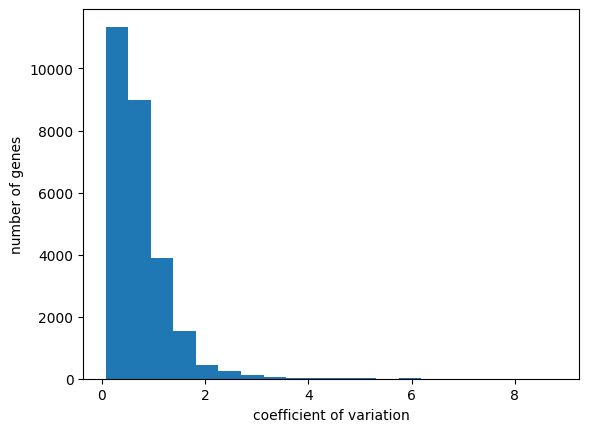

In [ ]:
# call filter_cvs with thresh=CV_THRESH
expr_df = filter_cvs(expr_df, thresh=CV_THRESH)
expr_df.shape

In [ ]:
# first save expr_df as genes x samples to file in gdrive for use in next notebook
expr_df.to_csv(DGEA_DIR + '/expr_df.csv', sep=',', index=None)

In [ ]:
# then transpose expr_df to be samples x genes
expr_df = transpose_df(expr_df, 'Unnamed: 0', 'sample')
expr_df.head()

,sample,ENSMUSG00000000028,ENSMUSG00000000031,ENSMUSG00000000049,ENSMUSG00000000093,ENSMUSG00000000094,ENSMUSG00000000120,ENSMUSG00000000125,ENSMUSG00000000126,ENSMUSG00000000142,...,ENSMUSG00000118344,ENSMUSG00000118353,ENSMUSG00000118364,ENSMUSG00000118365,ENSMUSG00000118369,ENSMUSG00000118377,ENSMUSG00000118378,ENSMUSG00000118379,ENSMUSG00000118380,ENSMUSG00000118383
0,Mmus_C57-6J_SKN_BSL_0days_Rep1_B1,71.0,5763.0,4.0,21.0,12.0,151.0,199.0,72.0,349.0,...,0.0,4.24,6.0,1.0,2.0,2.03,1.0,0.0,0.0,212.52
1,Mmus_C57-6J_SKN_BSL_0days_Rep2_B3,109.0,3297.0,1.0,11.0,17.0,132.0,228.0,50.0,361.0,...,0.0,6.06,3.0,0.0,4.0,1.01,2.0,1.0,3.0,145.20
2,Mmus_C57-6J_SKN_BSL_0days_Rep3_B5,70.0,3041.0,1.0,9.0,13.0,50.0,121.0,40.0,330.0,...,0.0,4.37,2.0,2.0,0.0,0.00,1.0,0.0,1.0,130.31
3,Mmus_C57-6J_SKN_BSL_0days_Rep4_B7,216.0,8334.0,6.0,72.0,37.0,508.0,816.0,203.0,1763.0,...,3.0,0.00,16.0,1.0,6.0,0.00,2.0,0.0,0.0,202.84
4,Mmus_C57-6J_SKN_BSL_0days_Rep5_B9,129.0,720.0,1.0,22.0,5.0,209.0,269.0,59.0,643.0,...,3.0,5.86,3.0,1.0,1.0,0.00,2.0,0.0,0.0,121.82


In [ ]:
# determine the shape of the transposed expr_df dataframe
expr_df.shape

(80, 15621)

In [ ]:
# read in  metadata

# NOTE: if you get an error (HTTP 404) in this cell, then open the link at the top of this section,
# find and copy the exact URL for the metadata ZIP file for your dataset, and replace the
# url variable below with the exact URL for your dataset.
# IMPORTANT NOTE: if you paste the URL from the OSDR Web page, then you need to insert the
# backslash ("\") character before the ampersand ("&") and the question mark ("?")
# in the url string, as shown in the example here.

url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + \
    '/download\?source=datamanager\&file=GLDS-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'


    #'/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_OSD-' + OSD_DATASET + '-ISA.zip'
    #'/download\?source=datamanager\&file=GLDS-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'
    #'/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'
    #'/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_OSD-' + GLDS_DATASET + '-ISA.zip'


!curl -L {url} -o  {META_DIR}/metadata-{OSD_DATASET}.zip
!unzip -o {META_DIR}/metadata-{OSD_DATASET}.zip -d {META_DIR}

<>:11: SyntaxWarning: invalid escape sequence '\?'
<>:11: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-1030456075.py:11: SyntaxWarning: invalid escape sequence '\?'
  '/download\?source=datamanager\&file=GLDS-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3846  100  3846    0     0   6069      0 --:--:-- --:--:-- --:--:--  6075
100 19417  100 19417    0     0  20715      0 --:--:-- --:--:-- --:--:-- 79905
Archive:  /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/254/FLT_vs_GC/META//metadata-254.zip
  inflating: /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/254/FLT_vs_GC/META/a_rr7_skn_transcription_profiling_RNA_Sequencing_(RNA-Seq).txt  
  inflating: /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/254/FLT_vs_GC/META/s_RR7_SKN.txt  
  inflating: /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/254/FLT_vs_GC/META/i_Investigation1.txt  


In [ ]:
# check metadata
# meta_df = pd.read_csv(f"{META_DIR}/s_OSD-" + OSD_DATASET + ".txt", sep='\t')
# meta_df = pd.read_csv(f"{META_DIR}/s_GLDS-" + OSD_DATASET + ".txt", sep='\t')
#meta_df = pd.read_csv(f"{META_DIR}/" + "s_RR6_LVR.txt", sep='\t')
meta_df = pd.read_csv(f"{META_DIR}" + "/s_RR7_SKN.txt", sep='\t')
meta_df.head()


,Source Name,Sample Name,Comment[LSDA Biospecimen Subject ID],Comment[LSDA Biospecimen Source ID],Characteristics[Organism],Term Source REF,Term Accession Number,Factor Value[Strain],Term Source REF.1,Term Accession Number.1,...,Comment[Launch Date],Comment[Euthanasia Date],Comment[BSP Dissection Date],Parameter Value[Sample Preservation Method],Term Source REF.11,Term Accession Number.11,Parameter Value[Sample Storage Temperature],Unit.3,Term Source REF.12,Term Accession Number.12
0,B1,Mmus_C57-6J_SKN_BSL_0days_Rep1_B1,693,6571,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,...,29-Jun-18,30-Jun-18,1-Feb-19,RNALater,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027
1,B3,Mmus_C57-6J_SKN_BSL_0days_Rep2_B3,693,6571,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,...,29-Jun-18,30-Jun-18,1-Feb-19,RNALater,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027
2,B5,Mmus_C57-6J_SKN_BSL_0days_Rep3_B5,693,6571,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,...,29-Jun-18,30-Jun-18,4-Feb-19,RNALater,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027
3,B7,Mmus_C57-6J_SKN_BSL_0days_Rep4_B7,693,6571,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,...,29-Jun-18,30-Jun-18,4-Feb-19,RNALater,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027
4,B9,Mmus_C57-6J_SKN_BSL_0days_Rep5_B9,693,6571,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,...,29-Jun-18,30-Jun-18,4-Feb-19,RNALater,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,-80,degree Celsius,UO,http://purl.obolibrary.org/obo/UO_0000027


In [ ]:
# list out all the columns of metadata and show the set of values for each
# NOTE: you can use this output to help determine other non-spaceflight factors
# you may wish to include in your experiment

metadata_cols = list(meta_df.columns)
for col in metadata_cols:
  print('column name: ', col)
  print('set of possible values: ', set(meta_df[col]))
  print('_______________')

column name:  Source Name
set of possible values:  {'V2', 'V18', 'GC11', 'V12', 'B14', 'B8', 'F13', 'F18', 'F12', 'V5', 'GC9', 'B4', 'B20', 'GC17', 'B17', 'GC16', 'B19', 'V3', 'B13', 'V20', 'GC14', 'V15', 'GC8', 'GC1', 'GC13', 'GC4', 'B10', 'F20', 'F2', 'F1', 'F19', 'GC12', 'F17', 'GC5', 'V1', 'V19', 'B6', 'V10', 'F15', 'F7', 'V13', 'GC18', 'V4', 'F14', 'F11', 'GC7', 'F6', 'V16', 'GC3', 'B9', 'GC10', 'B15', 'B1', 'B12', 'B3', 'F3', 'F16', 'GC2', 'F4', 'V6', 'B16', 'F5', 'V7', 'GC20', 'B11', 'GC19', 'GC6', 'V8', 'B5', 'F8', 'V11', 'V9', 'B18', 'GC15', 'V14', 'F10', 'B7', 'B2', 'F9', 'V17'}
_______________
column name:  Sample Name
set of possible values:  {'Mmus_C3H-HeJ_SKN_FLT_75days_Rep2_F8', 'Mmus_C57-6J_SKN_FLT_75days_Rep1_F3', 'Mmus_C3H-HeJ_SKN_GC_25days_Rep1_G2', 'Mmus_C57-6J_SKN_GC_25days_Rep5_G17', 'Mmus_C57-6J_SKN_GC_25days_Rep2_G5', 'Mmus_C57-6J_SKN_GC_75days_Rep2_G7', 'Mmus_C3H-HeJ_SKN_GC_75days_Rep1_G4', 'Mmus_C3H-HeJ_SKN_VIV_75days_Rep1_V4', 'Mmus_C57-6J_SKN_FLT_25days_Rep2

In [ ]:
# see how many samples are in each group
group_A = config['group_A']
group_B = config['group_B']
group_list = [group_A, group_B]
for group in group_list:
  print('number of samples per factor in group: ', group)
  for factor in group:
    print(meta_df[factor].value_counts())
  print()

number of samples per factor in group:  {'Factor Value[Spaceflight]': 'Space Flight'}
Factor Value[Spaceflight]
Basal Control       20
Space Flight        20
Ground Control      20
Vivarium Control    20
Name: count, dtype: int64

number of samples per factor in group:  {'Factor Value[Spaceflight]': 'Ground Control'}
Factor Value[Spaceflight]
Basal Control       20
Space Flight        20
Ground Control      20
Vivarium Control    20
Name: count, dtype: int64



In [ ]:
# check shape of  dataframes prior to analysis
print('expr shape: ', expr_df.shape)
print('meta shape: ', meta_df.shape)

expr shape:  (80, 15621)
meta shape:  (80, 54)


In [ ]:
# compare expr_df sample naming with meta_df sample naming
# note there could be a conflict here that breaks the rest of the analysis
expr_sample_set = set(expr_df['sample'])
meta_sample_set = set(meta_df['Sample Name'])
meta_source_set = set(meta_df['Source Name'])
print('expr samples: ', expr_sample_set)
print('meta samples: ', meta_sample_set)
print('meta sources: ', meta_source_set)

expr samples:  {'Mmus_C3H-HeJ_SKN_FLT_75days_Rep2_F8', 'Mmus_C57-6J_SKN_FLT_75days_Rep1_F3', 'Mmus_C3H-HeJ_SKN_GC_25days_Rep1_G2', 'Mmus_C57-6J_SKN_GC_25days_Rep5_G17', 'Mmus_C57-6J_SKN_GC_25days_Rep2_G5', 'Mmus_C57-6J_SKN_GC_75days_Rep2_G7', 'Mmus_C3H-HeJ_SKN_GC_75days_Rep1_G4', 'Mmus_C3H-HeJ_SKN_VIV_75days_Rep1_V4', 'Mmus_C57-6J_SKN_FLT_25days_Rep2_F5', 'Mmus_C57-6J_SKN_BSL_0days_Rep7_B13', 'Mmus_C57-6J_SKN_FLT_75days_Rep5_F19', 'Mmus_C57-6J_SKN_VIV_75days_Rep5_V19', 'Mmus_C57-6J_SKN_BSL_0days_Rep4_B7', 'Mmus_C57-6J_SKN_VIV_25days_Rep5_V17', 'Mmus_C57-6J_SKN_VIV_75days_Rep2_V7', 'Mmus_C3H-HeJ_SKN_BSL_0days_Rep1_B2', 'Mmus_C57-6J_SKN_FLT_75days_Rep4_F15', 'Mmus_C3H-HeJ_SKN_VIV_25days_Rep2_V6', 'Mmus_C3H-HeJ_SKN_FLT_25days_Rep5_F18', 'Mmus_C3H-HeJ_SKN_BSL_0days_Rep8_B16', 'Mmus_C3H-HeJ_SKN_BSL_0days_Rep7_B14', 'Mmus_C57-6J_SKN_BSL_0days_Rep2_B3', 'Mmus_C3H-HeJ_SKN_GC_75days_Rep2_G8', 'Mmus_C3H-HeJ_SKN_VIV_25days_Rep4_V14', 'Mmus_C57-6J_SKN_GC_75days_Rep4_G11', 'Mmus_C3H-HeJ_SKN_FLT_25d

In [ ]:
# intersect expr_df and meta_df samples
expr_sample_set = set(expr_df['sample'])
meta_sample_set = set(meta_df['Sample Name'])

common_samples = expr_sample_set.intersection(meta_sample_set)
print('number of common samples: ', len(common_samples))

expr_df = expr_df[expr_df['sample'].isin(common_samples)]
meta_df = meta_df[meta_df['Sample Name'].isin(common_samples)]

assert len(expr_df) == len(meta_df)

number of common samples:  80


# Prepare factors

In [ ]:
# First let's create a factors table.
# We'll assign 0 for one group and 1 for the other group
factors = pd.DataFrame(columns=['factor'])

group_A = config['group_A']
group_B = config['group_B']
group_list = [group_A, group_B]
factor_list = config['factor_list']

group_A_samples = set()
counter = 0
for factor in factor_list:
  if counter == 0:
    group_A_samples = set(meta_df[meta_df[factor] == group_A[factor]]['Sample Name'])
  else:
    group_A_samples = group_A_samples.intersection(set(meta_df[meta_df[factor] == group_A[factor]]['Sample Name']))
  counter += 1
print('group A samples: ', group_A_samples)

group_A_dict = dict()
for sample in group_A_samples:
  group_A_dict[sample] = '0'

group_B_samples = set()
counter = 0
for factor in factor_list:
  if counter == 0:
    group_B_samples = set(meta_df[meta_df[factor] == group_B[factor]]['Sample Name'])
  else:
    group_B_samples = group_B_samples.intersection(set(meta_df[meta_df[factor] == group_B[factor]]['Sample Name']))
  counter += 1
print('group B samples: ', group_B_samples)


group_B_dict = dict()
for sample in group_B_samples:
  group_B_dict[sample] = '1'

factors_A = pd.DataFrame.from_dict(group_A_dict, columns = ['factor'], orient='index')
factors_B = pd.DataFrame.from_dict(group_B_dict, columns = ['factor'], orient='index')
factors = pd.concat([factors_A, factors_B])
print('factors: ', factors)
factors.to_csv(DGEA_DIR + '/factors.csv')



group A samples:  {'Mmus_C57-6J_SKN_FLT_25days_Rep5_F17', 'Mmus_C3H-HeJ_SKN_FLT_25days_Rep5_F18', 'Mmus_C3H-HeJ_SKN_FLT_75days_Rep2_F8', 'Mmus_C57-6J_SKN_FLT_75days_Rep1_F3', 'Mmus_C57-6J_SKN_FLT_25days_Rep3_F9', 'Mmus_C57-6J_SKN_FLT_75days_Rep3_F11', 'Mmus_C3H-HeJ_SKN_FLT_75days_Rep1_F4', 'Mmus_C57-6J_SKN_FLT_75days_Rep2_F7', 'Mmus_C3H-HeJ_SKN_FLT_25days_Rep4_F14', 'Mmus_C3H-HeJ_SKN_FLT_25days_Rep1_F2', 'Mmus_C57-6J_SKN_FLT_25days_Rep2_F5', 'Mmus_C57-6J_SKN_FLT_25days_Rep4_F13', 'Mmus_C57-6J_SKN_FLT_75days_Rep5_F19', 'Mmus_C57-6J_SKN_FLT_25days_Rep1_F1', 'Mmus_C3H-HeJ_SKN_FLT_75days_Rep3_F12', 'Mmus_C3H-HeJ_SKN_FLT_25days_Rep2_F6', 'Mmus_C3H-HeJ_SKN_FLT_25days_Rep3_F10', 'Mmus_C3H-HeJ_SKN_FLT_75days_Rep5_F20', 'Mmus_C57-6J_SKN_FLT_75days_Rep4_F15', 'Mmus_C3H-HeJ_SKN_FLT_75days_Rep4_F16'}
group B samples:  {'Mmus_C57-6J_SKN_GC_25days_Rep4_G13', 'Mmus_C3H-HeJ_SKN_GC_25days_Rep4_G14', 'Mmus_C3H-HeJ_SKN_GC_25days_Rep1_G2', 'Mmus_C57-6J_SKN_GC_25days_Rep5_G17', 'Mmus_C57-6J_SKN_GC_25days_R

In [ ]:
# assert that there are at least 3 samples per group
# STOP here either of these assertions fail
# DGEA needs at least 3 biological replicates per group for the results to be meaningful
print(len(group_A_samples))
print(len(group_B_samples))

assert len(group_A_samples) >= 3
assert len(group_B_samples) >= 3

20
20


In [ ]:
# drop all values from expr_df and meta_df that are not in factors
_0 = list(factors[factors['factor'] == '0'].index)
_1 = list(factors[factors['factor'] == '1'].index)
samples = set(_0 + _1)
expr_df_samples = set(expr_df['sample'])
meta_df_samples = set(meta_df['Sample Name'])
final_samples = expr_df_samples.intersection(meta_df_samples).intersection(samples)

samples_0 = list(set(_0).intersection(final_samples))
samples_1 = list(set(_1).intersection(final_samples))

# create new df's expr_df_factors and meta_df_factors for use in the rest of this notebook
expr_df_factors = expr_df[expr_df['sample'].isin(final_samples)]
meta_df_factors = meta_df[meta_df['Sample Name'].isin(final_samples)]

# save dataframes to google drive
expr_df_factors.to_csv(DGEA_DIR + '/expr_df_factors.csv', sep=',', index=None)
meta_df_factors.to_csv(DGEA_DIR + '/meta_df_factors.csv', sep=',', index=None)

In [ ]:
# show the shape of the meta_df_factors
meta_df_factors.shape

(40, 54)

In [ ]:
# show the shape of the expr_df_factors
expr_df_factors.shape

(40, 15621)

In [ ]:
# assert that the number of samples is the same in meta_df_factors and expr_df_factors
# STOP here if they are not and figure out what the problem may be
assert meta_df_factors.shape[0] == expr_df_factors.shape[0]

# Run PCA

Here we run principal components analysis (PCA) to determine if the samples separate in the plane.

explained variance ratio (first two components): [0.49879509 0.42589449]


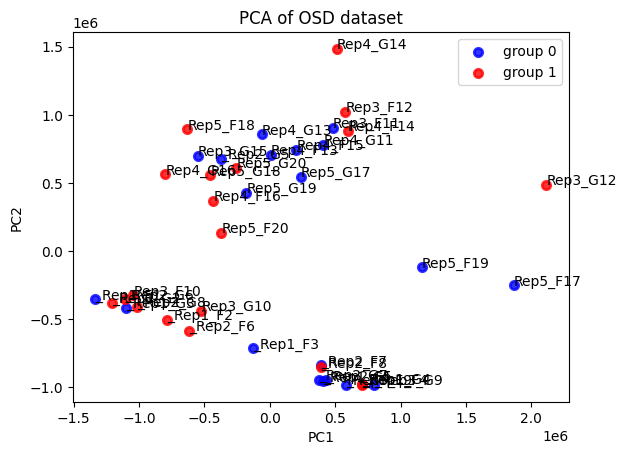

In [ ]:
# call run_pca on expr_df_factors
plt = run_pca(expr_df_factors, meta_df_factors, samples_0, samples_1, list(factors['factor']))
plt.savefig(DGEA_DIR + '/pca.png')
plt.show()

If you encounter any outliers,  you may wish to remove them from your expr_df_factors and meta_df_factors dataframes before running DGEA.

# Perform differential gene expression analysis

In [ ]:
# create dataframe with 'sample' column removed for DESeq2
import numpy as np
counts = expr_df_factors.drop(columns=['sample']).reset_index(drop=True)
# check for non-numeric
counts.applymap(np.isreal)
# convert all cells to integers
counts = counts.astype(int)
counts.shape

(40, 15620)

You can read more about the pyDeseq2 package in [this document](https://pydeseq2.readthedocs.io/en/stable/api/index.html#).

In [ ]:
# run the DESEq2 experiment contrasting condition "0" (ground control) to condition "1" (space flight)
# store the results in a dataframe called "res"
dds = DeseqDataSet(counts=counts, metadata=factors, design_factors="factor")
dds.deseq2()
stats_results = DeseqStats(dds, contrast = ('factor', '0', '1'))
stats_results.summary()
res = stats_results.results_df

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipython-input-1809659324.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts=counts, metadata=factors, design_factors="factor")
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 25.50 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 31.19 seconds.

Fitting LFCs...
... done in 16.72 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 341 outlier genes.

Fitting dispersions...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 0.57 seconds.

Fitting LFCs...
... done in 0.53 seconds.

Running Wald tests...
... done in 6.77 seconds.



Log2 fold change & Wald test p-value: factor 0 vs 1
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000000028   175.817957       -0.194532  0.168860 -1.152032  0.249308   
ENSMUSG00000000031  4684.292984        0.109468  0.272584  0.401595  0.687982   
ENSMUSG00000000049     2.538986       -0.129570  0.500854 -0.258698  0.795868   
ENSMUSG00000000093    34.576662        0.414852  0.193022  2.149252  0.031614   
ENSMUSG00000000094    14.939373        0.648031  0.247814  2.614986  0.008923   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000118377     1.195807        0.451598  0.562593  0.802709  0.422143   
ENSMUSG00000118378     3.705718       -0.939794  0.324865 -2.892874  0.003817   
ENSMUSG00000118379     1.018042       -0.723780  0.822875 -0.879575  0.379090   
ENSMUSG00000118380     1.176512        0.492779  0.597579  0.824626  0.409584   
ENSMUSG00000118383   252.445839        0.424920  0.354718

In [ ]:
# extract results of the DESeq2 experiment where  padj < 0.05, and log2fc > LOG2FC_THRESH
sigs = res[(res.padj < ALPHA_LEVEL) & (abs(res.log2FoldChange) > LOG2FC_THRESH)]
print(sigs.shape)
# convert gene id to gene symbol
sigs['gene_symbol'] = get_symbol_from_id(list(sigs.index))
print('first 5 sigs: ', sigs.head())
sigs.to_csv(DGEA_DIR + '/sigs.csv', sep=',')

INFO:biothings.client:querying 1-1000 ...


(1632, 6)


INFO:biothings.client:querying 1001-1632 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


first 5 sigs:                        baseMean  log2FoldChange     lfcSE       stat  \
ENSMUSG00000000248  113.509651        4.068319  0.405631  10.029599   
ENSMUSG00000000365   14.524810        3.023007  0.496889   6.083863   
ENSMUSG00000000381    4.690672       -5.224677  1.774081  -2.945004   
ENSMUSG00000000706  208.537918       -3.296653  0.716152  -4.603287   
ENSMUSG00000000983  520.135740       -2.672141  0.604035  -4.423822   

                          pvalue          padj gene_symbol  
ENSMUSG00000000248  1.129749e-23  7.087019e-22      Clec2g  
ENSMUSG00000000365  1.173211e-09  2.563015e-08       Rnf17  
ENSMUSG00000000381  3.229506e-03  2.009757e-02         Wap  
ENSMUSG00000000706  4.158743e-06  5.408790e-05      Btn1a1  
ENSMUSG00000000983  9.696992e-06  1.170533e-04      Wfdc18  


/tmp/ipython-input-4204195135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs['gene_symbol'] = get_symbol_from_id(list(sigs.index))


In [ ]:
# write differentially expressed gene list to file
deg_genes = list(sigs.index)
deg_gene_symbols = get_symbol_from_id(deg_genes)
with open(f"{DGEA_DIR}/deg_genes.txt", "w") as f:
  for gene in deg_gene_symbols:
    f.write(gene + "\n")
f.close()

# check gene file
!head {DGEA_DIR}/deg_genes.txt

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-1632 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Clec2g
Rnf17
Wap
Btn1a1
Wfdc18
C1ql4
Slc26a3
Csn3
Cpa3
Rec8


In [ ]:
# write list of background genes to file
bg_genes = get_symbol_from_id(list(expr_df.drop(columns=['sample'])))

with open(f"{DGEA_DIR}/background_genes.txt", "w") as f:
  for gene in bg_genes:
    f.write(gene + "\n")
f.close()

# check gene file
!head {DGEA_DIR}/background_genes.txt

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-15620 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Cdc45
H19
Apoh
Tbx2
Tbx4
Ngfr
Wnt3
Wnt9a
Axin2
Brat1


# Create volcano plot

You can learn more about how this volcano plot was generated reading [this article](https://bioinformatics.ccr.cancer.gov/docs/pies-2023/pies_lesson4/).

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:biothings.client:querying 1-20 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:Finished.


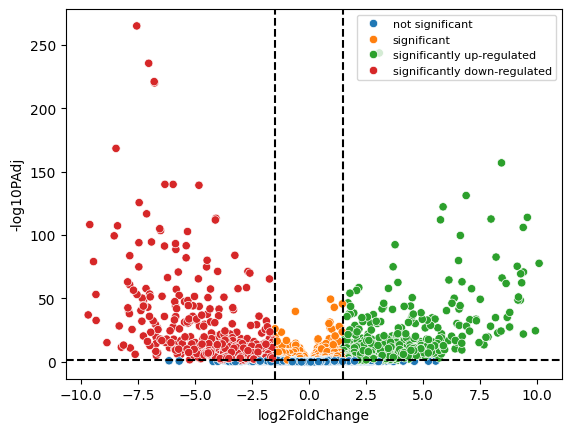

In [ ]:
# import Python modules for plotting volcano
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

# create column for -log10PAdj from existing padj
res['-log10PAdj'] = -numpy.log10(res['padj'])

# create column for significance from existing log2FoldChange and -log10PAdj
significance = []
for i in range(len(res)):
    if res.iloc[i]['log2FoldChange'] > LOG2FC_THRESH and res.iloc[i]['-log10PAdj'] > -numpy.log10(ALPHA_LEVEL):
        significance.append('significantly up-regulated')
    elif res.iloc[i]['log2FoldChange'] < -LOG2FC_THRESH and res.iloc[i]['-log10PAdj'] > -numpy.log10(ALPHA_LEVEL):
        significance.append('significantly down-regulated')
    elif res.iloc[i]['-log10PAdj'] > -numpy.log10(ALPHA_LEVEL) and res.iloc[i]['padj'] < ALPHA_LEVEL:
        significance.append('significant')
    else:
        significance.append('not significant')

res['significance'] = significance
# plot the degs
plot1 = seaborn.scatterplot(res, x = "log2FoldChange", y = "-log10PAdj", hue = "significance")

# sort to get top 10 significant genes
top10 = sigs[sigs['padj'] < ALPHA_LEVEL].sort_values(by=['log2FoldChange','padj'], ascending=[False, True]).head(20)

# add gene_symbol to top10
gene_symbol_list = get_symbol_from_id(list(top10.index))
top10['gene_symbol'] = gene_symbol_list

# add -log10PAdj to top10
top10['-log10PAdj'] = -numpy.log10(top10['padj'])

# # annotate top 10 significant genes
# for i in range(top10.shape[0]):
#     gene = top10.iloc[i]
#     plt.text(gene['log2FoldChange'], gene['-log10PAdj'], gene['gene_symbol'], fontsize=7, ha='right')

genes_of_interest = ["Ccl21d", "Ccl21f", "Skint9"]

selected = sigs.loc[sigs.index.isin(genes_of_interest)].copy()

selected['gene_symbol'] = get_symbol_from_id(list(selected.index))

for i in range(selected.shape[0]):
    gene = selected.iloc[i]
    plt.text(gene['log2FoldChange'], gene['-log10PAdj'], gene['gene_symbol'],
             fontsize=7, ha='right')


# draw a line at y=5 for significance
plt.axhline(y = -numpy.log10(ALPHA_LEVEL), color='black', linestyle='--')

# draw 2 lines at fold change threshold
plt.axvline(x = LOG2FC_THRESH, color = 'black', linestyle='--')
plt.axvline(x = -LOG2FC_THRESH, color='black', linestyle='--')

# set font size for legend
plt.legend(fontsize=8)

plt.savefig(DGEA_DIR + '/volcano.png')

plt.show()

The horizontal line (y=-numpy.log10(ALPHA_LEVEL) represents the negative log of the p-value threshold for the adjusted p-values (-log10PAdj). The value 0.05 is the standard alpha level of significance for most scientific research. We defined ALPHA_LEVEL at the top of this notebook. You can read more about the alpha level of significance [here](https://en.wikipedia.org/wiki/Statistical_significance).

The two vertical lines (x=-LOG2FC_THRESH and x=+LOG2FC_THRESH) represent the number of times up- and down-regulated the gene expression value is between the 2 conditions of the 2 groups, respectively. We defined the LOG2FC_THRESH value at the top of this notebook. You can read more about the log2 fold-change threshold for DGEA [here](https://www.biostars.org/p/9505003/).

The list of differentially expressed genes include those which are significantly down-regulated (in green) and significantly up-regulated (in red). Note that only the top 10 most significant genes are annotated.

# Check your work before moving on

In [ ]:
# make sure your google drive disk space utilization is still under 15G
# should be about 2.4GB
!du -sh /content/mnt/MyDrive/NASA/GL4HS

2.4G	/content/mnt/MyDrive/NASA/GL4HS


In [ ]:
# time the notebook
import datetime
end_time = datetime.datetime.now()
print('notebook end time: ', end_time.strftime('%Y-%m-%d %H:%M:%S'))

print('notebook runtime: ', end_time - start_time)
#

notebook end time:  2025-09-21 22:08:45
notebook runtime:  0:03:43.539888
